# FEVER 

A large part of the work here is to process the datasets and prepare them for training.

In this notebook, we will first focus on extracting the data from the pre-processed Wiki corpus provided by [fever.ai](https://fever.ai/dataset/fever.html).

The datasets are available as JSONL files. 

The data is available in a [docker image](https://hub.docker.com/r/feverai/common), 21GB in size. The container is created and the volume /local/ from it is mounted and made available to our [container](https://github.com/dmayukh/fakenews/Dockerfile) 

We use the following repos for reference code:

- [fever-baselines](https://github.com/klimzaporojets/fever-baselines.git)
- [fever-allennlp-reader](https://github.com/j6mes/fever-allennlp-reader)
- [fever-allennlp](https://github.com/j6mes/fever-allennlp)

Note, AllenNLP here is used only for the NLI training, using models such as Decomposable Attention, Elmo + ESIM, ESIM etc. We will not use those for our work here.


We will install a few dependencies such as:
- numpy>=1.15
- regex
- allennlp==2.5.0
- fever-scorer==2.0.39
- fever-drqa==1.0.13

The following packages are installed by the above dependencies
- torchvision-0.9.1
- google_cloud_storage-1.38.0
- overrides==3.1.0
- transformers-4.6.1
- spacy-3.0.6
- sentencepiece-0.1.96
- torch-1.8.1
- wandb-0.10.33
- lmdb-1.2.1
- jsonnet-0.17.0

We do not really need allennlp or fever-scorer as of yet, we would only need DrQA. We would prefer to use the DrQA from the official github, but for now we will go with what was prepackaged by the [j6mes](https://pypi.org/project/fever-drqa/) 

### Train the ESIM model on Fever dataset

The supplied dataset in the train.jsonl has NEI (not enough info) classes which do not have evidences annotated.

First we would prepare the dataset by generating closest document matches for the NEI classes.

The resulting dataset would have the original samples and for the NEI classes the evidence would contain the predicted, i.e. documents that match closely with the claim.

In [16]:
from mda.src.dataset.DatasetGenerator import DatasetGenerator

In [17]:
ds_generator = DatasetGenerator(dataset_root='data/data/',out_dir='working/data/training/', database_path='data/data/fever/fever.db')

In [3]:
ds_generator.generate_nei_evidences('train', 5)

Writing data to working/data/training//train.ns.pages.p5.jsonl


100%|██████████| 145449/145449 [25:12<00:00, 96.19it/s] 


#### Load the training data

In [1]:
from mda.src.dataset.DatasetReader import DatasetReader

In [2]:
infile = 'working/data/training/train.ns.pages.p5.jsonl'
dsreader = DatasetReader(in_file=infile,label_checkpoint_file=None, database_path='data/data/fever/fever.db')
raw, data = dsreader.read()
ds_train = dsreader.get_dataset()
print(ds_train.element_spec)

100%|██████████| 145449/145449 [00:01<00:00, 143734.96it/s]


(TensorSpec(shape=(2,), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))


In [3]:
for d in ds_train.take(1):
    print(d)

(<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'[START] nikolaj coster waldau worked with the fox broadcasting company . [END]',
       b'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot . The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .'],
      dtype=object)>, <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 1], dtype=int32)>)


### Load the dev data

NOTE: the dev data is sampled differently than training data when running evaluation, this is because during validation, we are supposed to select the relevant pages and the sentences from those pages which will be used for our evaluation task, but during the training validation data comes from the dev dataset for which the pages and sentences chosen would be the ones annotated in the dataset and therefore which should be processed just like the train data, i.e. using the annotated evidences.

#### Generate NEI evidences for dev dataset

In [18]:
ds_generator.generate_nei_evidences('paper_dev', 5)

  0%|          | 2/9999 [00:00<08:48, 18.91it/s]

Writing data to working/data/training//paper_dev.ns.pages.p5.jsonl


100%|██████████| 9999/9999 [02:19<00:00, 71.57it/s] 


In [4]:
infile = 'working/data/training/paper_dev.ns.pages.p5.jsonl'
label_checkpoint_file = 'working/data/training/label_encoder_train.pkl'
#note, use type = 'train' since formatting would be like the train examples
dsreader = DatasetReader(in_file=infile,label_checkpoint_file=label_checkpoint_file, database_path='data/data/fever/fever.db', type='train')
raw_dev, data_dev = dsreader.read()
ds_dev = dsreader.get_dataset()

100%|██████████| 9999/9999 [00:00<00:00, 195211.49it/s]


In [5]:
for d in ds_dev.take(1):
    print(d)

(<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'[START] colin kaepernick became a starting quarterback during the ers rd season in the national football league . [END]',
       b'During the 2013 season , his first full season as a starter , Kaepernick helped the 49ers reach the NFC Championship , losing to the Seattle Seahawks .'],
      dtype=object)>, <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 0, 0], dtype=int32)>)


In [6]:
import tensorflow as tf
import numpy as np
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [7]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

#### Use pre-generated vocab to initialize bert
Generating the vocab is an expensive operation and needs to be done using the full corpus of data, i.e. not just the sentences, but using the entire body text from the training dataset. If the vocab is already generated, use the vocab file to initialize the tokenizer.

In [8]:
bert_tokenizer_params=dict(lower_case=True)
vocab_file_out = 'working/data/fever_vocab.txt'
pt_tokenizer = text.BertTokenizer(vocab_file_out, **bert_tokenizer_params)

#### Generating the BERT vocab
If the vocab file is not available, generate the vocab file. Use the full dataset text generator for this task.

In [10]:
infile = 'working/data/training/paper_dev.ns.pages.p5.jsonl'
#note, use type = 'train' since formatting would be like the train examples
dsreader = DatasetReader(in_file=infile,label_checkpoint_file=None, database_path='data/data/fever/fever.db', type='train', fullbodytext=True)
raw_train_all, data_train_all = dsreader.read()
ds_train_tup = dsreader.get_dataset()
ds_train_text = ds_train_tup.map(lambda x, y: x)

100%|██████████| 9999/9999 [00:00<00:00, 192957.13it/s]


In [11]:
%%time
pt_vocab = bert_vocab.bert_vocab_from_dataset(
    ds_train_text.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 2min 11s, sys: 1.22 s, total: 2min 13s
Wall time: 2min 12s


In [62]:
def write_vocab_file(filepath, vocab):
    print("Saving vocab file to {}".format(filepath))
    with open(filepath, 'w') as f:
        for token in vocab:
            print(token, file=f)

In [63]:
vocab_file_out = 'working/data/fever_vocab.txt'
write_vocab_file(vocab_file_out, pt_vocab)

Saving vocab file to working/data/fever_vocab.txt


#### Tokenize the data
Tokenize the data and prepare the tensors for training. We will tokenize the texts, the hypothesis and the evidences seperately and return them as tensors in a BatchDataset.

Generate the BatchDataset for the training data.

In [22]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = ds_train.map(lambda x, y: tokenize_and_pad(x[0], MAX_SEQ_LEN))
e = ds_train.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
l = ds_train.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
dataset_train = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset_train)
print(dataset_train.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


Generate the BatchDataset for the test data.

In [23]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = ds_dev.map(lambda x, y: tokenize_and_pad(x[0], MAX_SEQ_LEN))
e = ds_dev.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
l = ds_dev.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
dataset_test = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset_test)
print(dataset_test.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


#### Prepare the glove embeddings

If this is the first time parsing glove, we will load them from the file downloaded from <> and prepare the embedding matrix.

If we already have an embedding matrix saved, we will simply load them from the saved object.

In [24]:
npzfile = np.load("working/data/embedding_mappings_300d.npz")
print(npzfile.files)
embedding_matrix = npzfile['arr_0']
print("Loaded an embedding matrix of shape", embedding_matrix.shape)

['arr_0']
Loaded an embedding matrix of shape (8001, 300)


If we did not have saved embeddings, we will need to parse them from scratch.

In [15]:
import zipfile, io
glove_zip_file = "entailment/data/glove.6B.zip"
glove_vectors_file = "glove.6B.300d.txt"
embeddings_index = {}
with zipfile.ZipFile(glove_zip_file) as z:
        for info in z.infolist():
            print(info.filename)
            if glove_vectors_file in info.filename:
                # read the file
                print("Reading lines from file {}".format(glove_vectors_file))
                with io.TextIOWrapper(z.open(glove_vectors_file), encoding="utf-8") as f:
                    for line in f:
                        terms = line.split()
                        word = terms[0]
                        coefs = np.asarray(terms[1:], dtype='float32')
                        
                        embeddings_index[word] = coefs

glove.6B.50d.txt
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
Reading lines from file glove.6B.300d.txt


Prepare the embedding matrix from the embedding index

In [53]:
max_length = embeddings_index['start'].shape[0]
vocab_size = 8000
embedding_matrix = np.zeros((vocab_size + 1, max_length))

In [54]:
# d is already a batch of 32 examples
for d in ds.batch(1):
    emb = pt_tokenizer.tokenize(d[0])
    embd = pt_tokenizer.detokenize(emb)
    word_batch = [[w[0].decode() for w in w_np] for w_np in [word.numpy() for word in embd]]
    index_batch = [[w[0] for w in w_np] for w_np in [word.numpy() for word in emb]]
    for w_batch, i_batch in zip(word_batch, index_batch):
        for w, i in zip(w_batch, i_batch):
            embedding_vector = embeddings_index.get(w)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

Save the embedding matrix to a compressed numpy file

In [55]:
embedding_file = "working/data/embedding_mappings_300d.npz"
np.savez(embedding_file, embedding_matrix)

#### Baseline NLI model using BiLSTM

From A large annotated corpus for learning natural language inference [Bowman et al.](https://arxiv.org/pdf/1508.05326v1.pdf), we use the idea of a network based on a BiLSTM. Instead of using 100D embeddings, we use 300D embeddings and use just one 'relu' layer instead of 2 stacked 'tanh' layers used by the authors of the paper.


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *

In [23]:
vocab_size= 8000
dim = 300
inp1 = keras.Input(shape=(None, ), name = "hypothesis")
inp2 = keras.Input(shape=(None, ), name = "evidence")
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
embedding_evi_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False)
x_hyp = embedding_hyp_layer(inp1)
x_evi = embedding_evi_layer(inp2)
lstm_layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_hyp)
lstm_layer2 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_evi)
w = keras.layers.concatenate([lstm_layer1, lstm_layer2], axis = 1)
x1 = tf.keras.layers.Dense(16, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu')(w)
x2 = tf.keras.layers.Dropout(0.3)(x1)
output = tf.keras.layers.Dense(3, activation='softmax')(x2)
model = keras.Model(inputs=[inp1, inp2], outputs=output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hypothesis (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
evidence (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    2400300     hypothesis[0][0]                 
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 300)    2400300     evidence[0][0]                   
______________________________________________________________________________________________

In [24]:
rm -rf tmp/checkpoint_fever_nli*

In [25]:
checkpoint_filepath = 'tmp/checkpoint_fever_nli'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [28]:
history = model.fit(dataset_train, epochs = 12, validation_data=dataset_test, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/12
2272/2272 [==============================] - 623s 248ms/step - loss: 0.7429 - accuracy: 0.7070 - val_loss: 0.8254 - val_accuracy: 0.6328
Epoch 2/12
2272/2272 [==============================] - 605s 245ms/step - loss: 0.6082 - accuracy: 0.7680 - val_loss: 0.8183 - val_accuracy: 0.6541
Epoch 3/12
2272/2272 [==============================] - 606s 245ms/step - loss: 0.5331 - accuracy: 0.8034 - val_loss: 0.8382 - val_accuracy: 0.6535
Epoch 4/12
2272/2272 [==============================] - 604s 244ms/step - loss: 0.4813 - accuracy: 0.8252 - val_loss: 0.9818 - val_accuracy: 0.6402
Epoch 5/12
2272/2272 [==============================] - 606s 245ms/step - loss: 0.4381 - accuracy: 0.8421 - val_loss: 1.0801 - val_accuracy: 0.6344
Epoch 6/12
2272/2272 [==============================] - 604s 245ms/step - loss: 0.4000 - accuracy: 0.8574 - val_loss: 1.1629 - val_accuracy: 0.6336
Epoch 7/12
2272/2272 [==============================] - 604s 244ms/step - loss: 0.3680 - accuracy: 0.8683 - val_

In [30]:
checkpoint_filepath = 'tmp/checkpoint_fever_nli'
model.load_weights(checkpoint_filepath)
model.evaluate(dataset_test)

156/156 [==============================] - 23s 44ms/step - loss: 0.8134 - accuracy: 0.6581


[0.813413679599762, 0.6580528616905212]

Text(0.5, 1.0, 'Metrics for training FEVER dataset, 145K samples (glove 300d)')

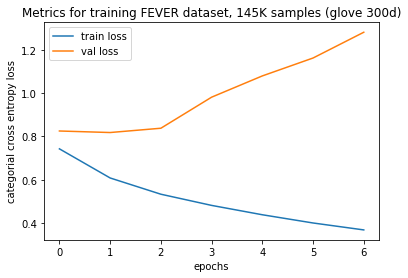

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training FEVER dataset, 145K samples (glove 300d)")

### Build the network

As observed above, the BiLSTM network with a relu dense layer did'nt do well even though it seemed to have done well in the SNLI tasks. One reason could be the length of the hypothesis in FEVER dataset. In SNLI dataset, the premise and the hypothesis are pretty much of the same length, whereas in our case the hypothesis is much longer due to the concatenation of multiple sentences from multiple documents.

We look at the results of the FEVER 2018 workshop where the 3rd place holder <b>UCL Machine Reading Group></b> with their [Four Factor Framework For Fact Finding (HexaF)](https://aclanthology.org/W18-5515.pdf) paper used a similar network with local inferenece encoding. They use an ESIM model [Chen et. al.](https://arxiv.org/abs/1609.06038) with the novelty in they way the results are aggregated.

We will use a similar approach, but we will use Bert tokenizers and use a simple aggregation technique instead of the complex MLP and majority vote based technique used by the authors.

The authors also used a pre-trained ESIM model on the SNLI dataset and fine tuned it on the FEVER dataset, which we did not do due to lack of time. One way to improve our results would be to perform this step.

We do much better than the original FEVER paper which had a classification accuracy of <b>32.57%</b>, and ignoring the requirement for correct evidence (NoScoreEv) the accuracy was <b>52.09%</b>, our results were <b>35.96%</b> and <b>56.39%</b> respectively.

We however do not perform better than <b>UCL Machine Reading Group</b> whose best score was <b>65.41%</b>. It however is not clear from their paper if this was a (NoScoreEv) or the actual FEVER score.

[The Fact Extraction and VERification (FEVER) Shared Task](https://aclanthology.org/W18-5501v3.pdf) details the scores for the teams, arranges by the label accuracy and the fever score on the test dataset.

Our label accuracy was <b>57.32%</b> and the fever score was <b>34.92%</b> which should have put us at 16th position by fever score.
Our label accuracy is however quite good and would have put us in the <b>top 6</b> if we were to only look at the accuracy of predicting the right label and ignore if we has selected the right evidence (sentence) to support or refute the claim. 

We refer to 'Keras ESIM', an implementation of [Chen et. al.](https://arxiv.org/abs/1609.06038) <b>Enhanced LSTM for Natural Language Inference</b> for the task of natural language inference.

Reference: https://github.com/dzdrav/kerasESIM

Optionally we could have used this https://gist.github.com/namakemono/f4f273dbc63fc2174940415a9f689a6f. The network representation is simpler in this form of the code.

In [25]:
from mda.src.model.esim import esim

In [26]:
esim_model = esim(embedding_matrix=embedding_matrix, vocab_size = 8000, embedding_dim=300, alignment_dense_dim=300, final_dense_dim=100)
model = esim_model.build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hypothesis (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
evidence (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 300)    2400300     hypothesis[0][0]                 
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 300)    2400300     evidence[0][0]                   
____________________________________________________________________________________________

In [27]:
#optionally delete the checkpoint file
!rm -rf tmp/attention_esim/checkpoint_fever_lstm_esim

In [28]:
checkpoint_filepath = 'tmp/attention_esim/checkpoint_fever_lstm_esim'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [29]:
history = model.fit(dataset_train, epochs = 30, validation_data=dataset_test, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/30
2272/2272 [==============================] - 900s 374ms/step - loss: 0.6680 - accuracy: 0.7255 - val_loss: 0.6550 - val_accuracy: 0.6953
Epoch 2/30
2272/2272 [==============================] - 894s 373ms/step - loss: 0.5213 - accuracy: 0.7972 - val_loss: 0.6117 - val_accuracy: 0.7327
Epoch 3/30
2272/2272 [==============================] - 898s 375ms/step - loss: 0.4595 - accuracy: 0.8244 - val_loss: 0.5362 - val_accuracy: 0.7731
Epoch 4/30
2272/2272 [==============================] - 899s 375ms/step - loss: 0.4148 - accuracy: 0.8440 - val_loss: 0.5534 - val_accuracy: 0.7733
Epoch 5/30
2272/2272 [==============================] - 898s 375ms/step - loss: 0.3900 - accuracy: 0.8544 - val_loss: 0.6225 - val_accuracy: 0.7664
Epoch 6/30
2272/2272 [==============================] - 897s 374ms/step - loss: 0.3683 - accuracy: 0.8619 - val_loss: 0.5720 - val_accuracy: 0.7792
Epoch 7/30
2272/2272 [==============================] - 898s 375ms/step - loss: 0.3544 - accuracy: 0.8680 - val_

In [30]:
checkpoint_filepath = 'tmp/attention_esim/checkpoint_fever_rte_esim'
model.load_weights(checkpoint_filepath)
model.evaluate(dataset_test)

156/156 [==============================] - 26s 68ms/step - loss: 0.5304 - accuracy: 0.8057


[0.5304155945777893, 0.8056890964508057]

Text(0.5, 1.0, 'Metrics for training FEVER dataset, 145K samples (glove 300d)')

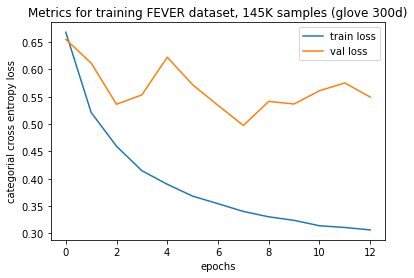

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training FEVER dataset, 145K samples (glove 300d)")
#history.history['loss']

In [34]:
ls working/data/training/

baseline/
baselinetrain.ns.pages.p5.jsonl
label_encoder_train.npz
label_encoder_train.pkl
paper_dev.ns.pages.p5.jsonl
paper_dev_pipeline.ps.pages.p5.jsonl
paper_dev_predicted_pipeline.ps.pages.p5.jsonl
paper_test.ns.pages.p5.jsonl
paper_test_pipeline.ns.pages.p5.jsonl
paper_test_pipeline.ps.pages.p5.jsonl
paper_test_predicted_pipeline.ps.pages.p5.jsonl
train.ns.pages.p5.jsonl
train.pages.p5.jsonl


In [36]:
### Save the training history
import pickle
with open('working/data/training/esim_rte_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#### Compute the classification metrics

In [37]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = ds_dev.map(lambda x, y: tokenize_and_pad(x[0], MAX_SEQ_LEN))
e = ds_dev.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
l = ds_dev.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
#do not shuffle for precision calculation
dataset_test_val = d.batch(BATCH_SIZE, drop_remainder=True)
print(dataset_test_val)
print(dataset_test_val.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


In [38]:
#extract the labels from the dev dataset and convert them into onehot
ds_y = dataset_test_val.map(lambda f, l: l)
print(ds_y)
y_test_onehot = []
for d in ds_y.batch(1):
    for d1 in d:
        y_test_onehot.append(d1.numpy())
y_test = np.array([np.argmax(a, axis=1) for a in y_test_onehot]).flatten()
y_test

<MapDataset shapes: (64, 3), types: tf.int32>


array([0, 0, 2, ..., 0, 0, 2])

In [39]:
#run prediction on the dev dataset
y_pred = model.predict(dataset_test_val)

In [40]:
y_pred_bool = np.argmax(y_pred, axis = 1)
y_pred_bool

array([2, 0, 2, ..., 0, 0, 2])

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bool))
#['NOT ENOUGH INFO', 'REFUTES', 'SUPPORTS'] == [0, 1, 2]

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3325
           1       0.85      0.67      0.75      3331
           2       0.71      0.88      0.78      3328

    accuracy                           0.80      9984
   macro avg       0.82      0.80      0.80      9984
weighted avg       0.82      0.80      0.80      9984

